一个最简单的神经网络 MLP（Multilayer Perceptron, 多层感知机）

https://github.com/christianversloot/machine-learning-articles/blob/main/creating-a-multilayer-perceptron-with-pytorch-and-lightning.md

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

class MLP(nn.Module):
  '''
  Multilayer Perceptron.
  '''
  def __init__(self): # constructor
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(), # 把图像展平成向量
      nn.Linear(32 * 32 * 3, 64), # 32pixel x 32pixel RGB image
      nn.ReLU(), # activation. you can also try sigmoid.
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 10)
    )

  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

这个简单的MLP模型中，输入的图像首先被flatten为一个向量。这种简单粗暴的处理丢失了像素之间的空间关系，后续的CNN和Attention较好解决了这个问题。


(dot.exe:31324): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


model is on: cuda:0


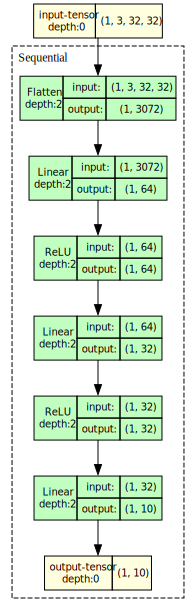

In [2]:
from torchview import draw_graph

device = 'cuda' if torch.cuda.is_available() else 'cpu'
mlp = MLP().to(device)

print('model is on:', next(mlp.parameters()).device)

model_graph = draw_graph(mlp, input_size=(1, 3, 32, 32), expand_nested=True) # device='meta', 
model_graph.visual_graph

## CIFAR 10 dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

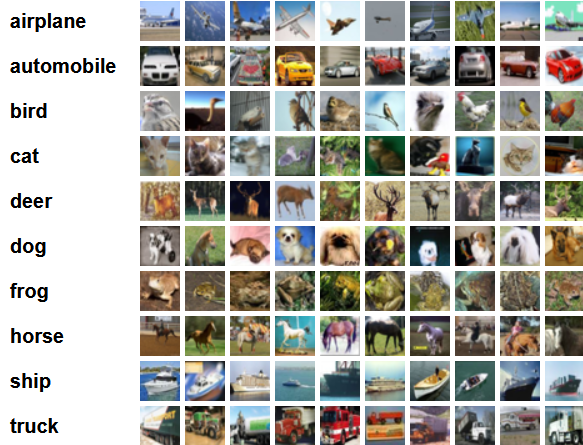

In [3]:
# Prepare CIFAR-10 dataset
from torchvision.datasets import CIFAR10, CIFAR100

dataset = CIFAR10("../data/", download=True, transform=transforms.ToTensor()) # os.getcwd()
trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=1)

Files already downloaded and verified


pyTorch中的dataset类型（包括各种内置公开数据集和ImageFolder等返回的数据集对象），具有`classes`和`class_to_idx`两个属性，可以方便得到类别名称和字典

In [4]:
dataset.__dir__()

['root',
 'transform',
 'target_transform',
 'transforms',
 'train',
 'data',
 'targets',
 'classes',
 'class_to_idx',
 '__module__',
 '__doc__',
 'base_folder',
 'url',
 'filename',
 'tgz_md5',
 'train_list',
 'test_list',
 'meta',
 '__init__',
 '_load_meta',
 '__getitem__',
 '__len__',
 '_check_integrity',
 'download',
 'extra_repr',
 '__parameters__',
 '_repr_indent',
 '__repr__',
 '_format_transform_repr',
 '__add__',
 '__orig_bases__',
 '__dict__',
 '__weakref__',
 '__class_getitem__',
 '__init_subclass__',
 '__annotations__',
 '__new__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__getstate__',
 '__subclasshook__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [5]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
dataset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

几个概念的解释：  
loss function，optimizer，epoch，backward

In [7]:
# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3) # Adam - 某种梯度下降算法，此处不展开; lr - learning rate
mlp.train()

loss_history = []
acc_history = []

# Run the training loop
for epoch in range(0, 50):
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0

    corrects = 0
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
        # Get inputs
        inputs, targets = data # X & y
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        outputs = mlp(inputs)
        
        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward() # 后向传播，计算所有参数的偏导数
        
        # Perform optimization
        optimizer.step() # 根据偏导数更新各个参数

        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == targets.data)
        
        # Print statistics
        current_loss += loss.item()
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
            loss_history.append(current_loss / 500)
            current_loss = 0.0

    acc = corrects.double().item() / len(dataset)
    print('acc =', acc)
    acc_history.append(acc)

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch   500: 2.089
Loss after mini-batch  1000: 1.924
Loss after mini-batch  1500: 1.891
Loss after mini-batch  2000: 1.827
Loss after mini-batch  2500: 1.815
Loss after mini-batch  3000: 1.775
acc = 0.3129
Starting epoch 2
Loss after mini-batch   500: 1.757
Loss after mini-batch  1000: 1.732
Loss after mini-batch  1500: 1.729
Loss after mini-batch  2000: 1.712
Loss after mini-batch  2500: 1.721
Loss after mini-batch  3000: 1.696
acc = 0.37856
Starting epoch 3
Loss after mini-batch   500: 1.683
Loss after mini-batch  1000: 1.675
Loss after mini-batch  1500: 1.677
Loss after mini-batch  2000: 1.667
Loss after mini-batch  2500: 1.661
Loss after mini-batch  3000: 1.659
acc = 0.40052
Starting epoch 4
Loss after mini-batch   500: 1.628
Loss after mini-batch  1000: 1.627
Loss after mini-batch  1500: 1.644
Loss after mini-batch  2000: 1.639
Loss after mini-batch  2500: 1.645
Loss after mini-batch  3000: 1.627
acc = 0.4128
Starting epoch 5
Loss after mini-batch

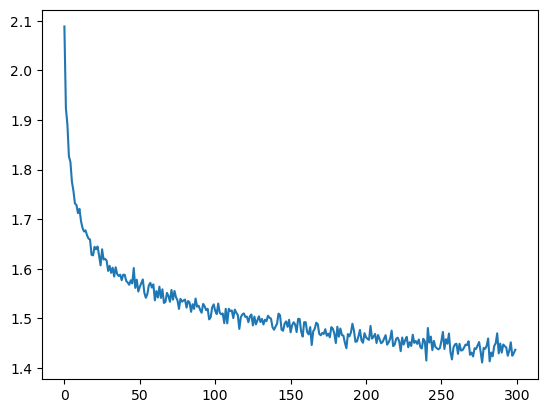

In [8]:
import matplotlib.pyplot as plt

plt.plot(loss_history)

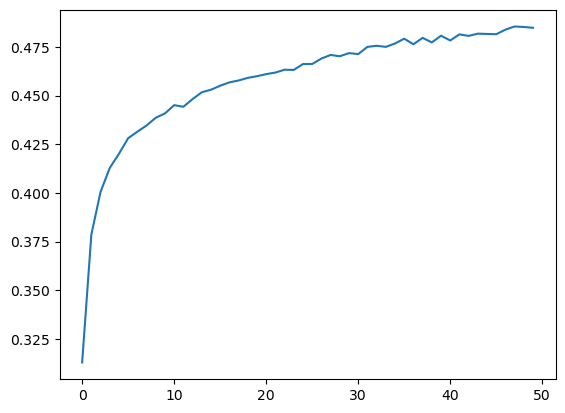

In [9]:
plt.plot(acc_history)

In [10]:
import matplotlib.pyplot as plt

def evaluate_rgb_images(model, dataloader, max_samples = 100):
    
    sample_cnt = 0
    correct = 0
    for inputs, labels in dataloader:
    
        if sample_cnt >= max_samples:
            break
        sample_cnt += len(labels)
        
        plt.figure(figsize=(10,len(inputs)/10+1))
        for idx, img  in enumerate(inputs):
            plt.subplot(int(len(inputs)/10)+1, 10, idx+1)       
            # x = img * STD[:, None, None] + MEAN[:, None, None]
            plt.imshow(img.numpy().transpose(1, 2, 0))
            plt.axis('off')
        plt.show()
        # Move the inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        print('truth: \n', labels)
        print('prediction: \n', preds)
        correct += (preds == labels).float().sum()
        
    accuracy = 100 * correct / sample_cnt
    print('classification accuracy (%) =', accuracy.item())

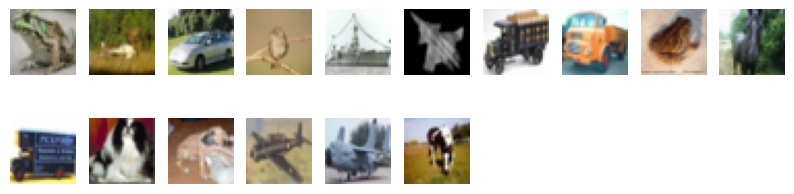

truth: 
 tensor([6, 4, 1, 2, 8, 0, 9, 9, 6, 7, 9, 5, 5, 0, 0, 7], device='cuda:0')
prediction: 
 tensor([6, 2, 1, 4, 8, 5, 9, 8, 6, 2, 9, 5, 3, 4, 9, 7], device='cuda:0')


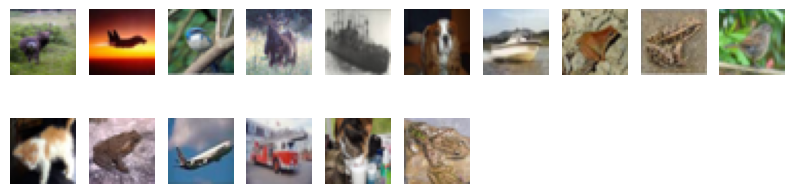

truth: 
 tensor([4, 0, 2, 4, 8, 5, 8, 6, 6, 2, 3, 6, 0, 9, 3, 6], device='cuda:0')
prediction: 
 tensor([2, 1, 5, 4, 6, 3, 8, 4, 6, 4, 1, 3, 0, 9, 3, 4], device='cuda:0')


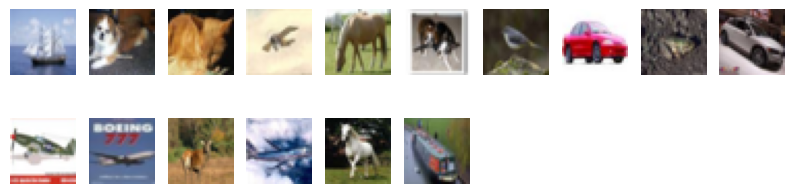

truth: 
 tensor([8, 5, 3, 0, 7, 5, 2, 1, 6, 1, 0, 0, 4, 0, 7, 8], device='cuda:0')
prediction: 
 tensor([8, 3, 6, 2, 7, 3, 4, 1, 6, 1, 0, 0, 4, 0, 7, 4], device='cuda:0')


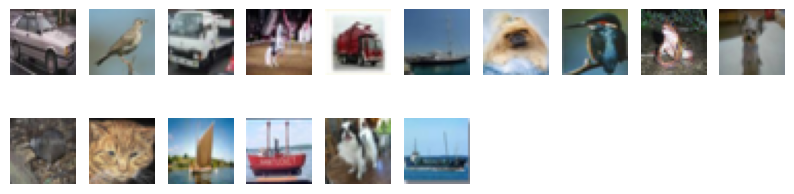

truth: 
 tensor([1, 2, 9, 7, 9, 8, 5, 2, 6, 5, 2, 3, 8, 8, 5, 8], device='cuda:0')
prediction: 
 tensor([1, 0, 1, 5, 9, 8, 5, 4, 6, 4, 4, 3, 2, 8, 3, 8], device='cuda:0')


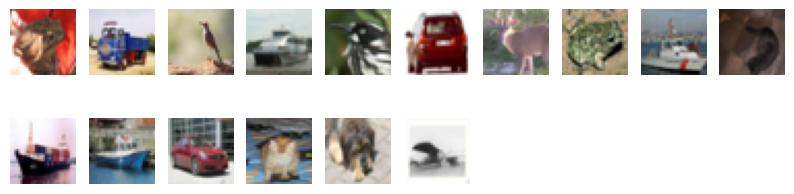

truth: 
 tensor([6, 9, 2, 8, 2, 1, 4, 6, 8, 3, 8, 8, 1, 3, 5, 0], device='cuda:0')
prediction: 
 tensor([6, 9, 2, 8, 4, 9, 2, 6, 8, 6, 1, 1, 1, 5, 5, 0], device='cuda:0')


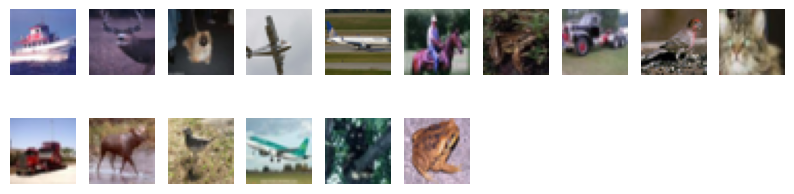

truth: 
 tensor([8, 4, 5, 0, 0, 7, 6, 9, 2, 3, 9, 4, 2, 0, 3, 6], device='cuda:0')
prediction: 
 tensor([8, 4, 6, 2, 2, 2, 6, 7, 2, 4, 9, 5, 2, 0, 2, 6], device='cuda:0')


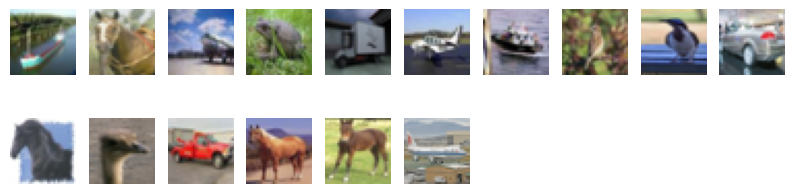

truth: 
 tensor([8, 7, 0, 6, 9, 0, 8, 2, 2, 1, 7, 2, 9, 7, 7, 0], device='cuda:0')
prediction: 
 tensor([8, 7, 0, 6, 9, 8, 8, 6, 0, 8, 2, 6, 1, 7, 7, 0], device='cuda:0')


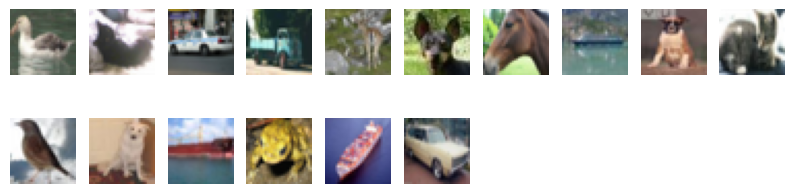

truth: 
 tensor([2, 3, 1, 9, 4, 5, 7, 8, 5, 3, 2, 5, 8, 6, 8, 1], device='cuda:0')
prediction: 
 tensor([4, 1, 1, 9, 4, 2, 7, 0, 3, 6, 2, 2, 8, 6, 0, 1], device='cuda:0')


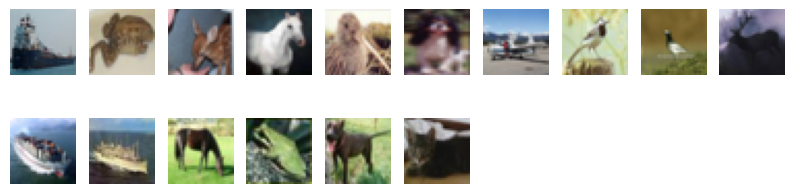

truth: 
 tensor([8, 6, 4, 7, 2, 5, 0, 2, 2, 4, 8, 8, 7, 6, 5, 3], device='cuda:0')
prediction: 
 tensor([8, 3, 4, 5, 7, 5, 0, 2, 2, 9, 8, 8, 7, 6, 7, 4], device='cuda:0')


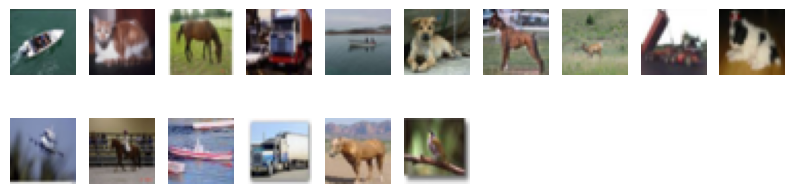

truth: 
 tensor([8, 3, 7, 9, 8, 5, 5, 4, 9, 5, 0, 7, 8, 9, 7, 2], device='cuda:0')
prediction: 
 tensor([8, 8, 7, 1, 8, 6, 7, 4, 9, 3, 0, 6, 8, 9, 7, 6], device='cuda:0')


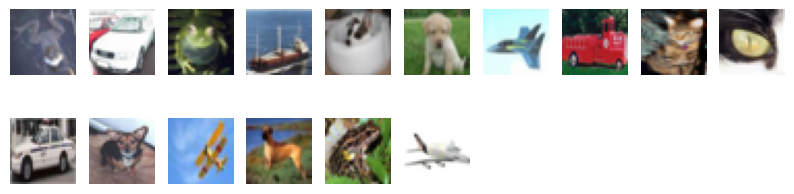

truth: 
 tensor([6, 1, 6, 8, 5, 5, 0, 9, 3, 3, 1, 5, 0, 5, 6, 0], device='cuda:0')
prediction: 
 tensor([8, 8, 6, 8, 5, 2, 0, 1, 6, 1, 1, 7, 0, 4, 4, 0], device='cuda:0')


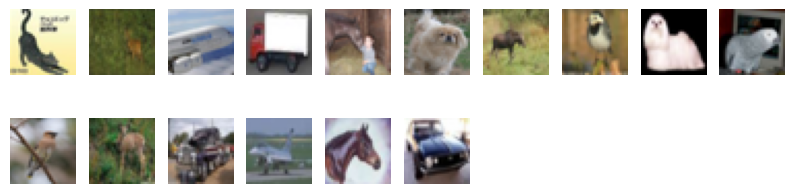

truth: 
 tensor([3, 4, 0, 9, 7, 5, 4, 2, 5, 2, 2, 4, 9, 0, 7, 1], device='cuda:0')
prediction: 
 tensor([7, 4, 0, 9, 3, 2, 4, 6, 5, 3, 2, 4, 9, 8, 7, 1], device='cuda:0')


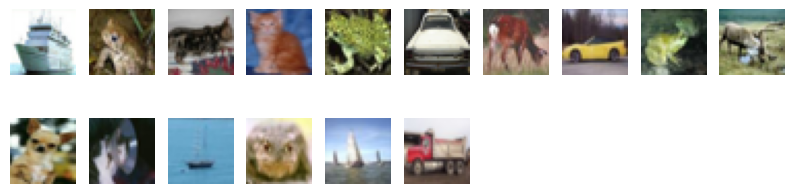

truth: 
 tensor([8, 6, 3, 3, 6, 1, 4, 1, 6, 4, 5, 3, 8, 6, 8, 9], device='cuda:0')
prediction: 
 tensor([8, 3, 7, 5, 6, 1, 7, 9, 6, 4, 4, 3, 8, 4, 0, 9], device='cuda:0')
classification accuracy (%) = 52.88461685180664


In [11]:
evaluate_rgb_images(mlp, trainloader, max_samples = 200)

在10分类问题上得到约 50% acc  
后续改进方向：conv；划分训练集/验证集/测试集

In [12]:
#TODO：改造 MNIST.ipynb